# Journey to Trip Advisor analysis 

## Task 0: Preparing and exploring data 

* After loading over 175M rows into BigQuery, the suggested table is created. 
* Column 'useragent' not found in transferred data.
* Strange values arise when observing timestamp lag differences.
* Using BigQuery's TIMESTAMP_SECONDS function (seconds count after 1970-01-01 00:00:00 UTC) shows missmatch between date and tranformed timestamp. 
* Padding timestamps to 10 digits 18M show difference on date and timestamp, and only 41K have differences greater than 1 day. 
* Padded timestamp are used to get the event time in DHW and the 'eventdate' timestamp is used for the 41K atypical values.
* Rows with NULL 'userid', 'eventdate'. or 'eventtimestamp' are removed.
* Column 'countrycode' appears to be misslabeled from origin, and in fact carries 'useragent' information, so column name will be changed in DWH tables.

In [1]:
from google.cloud import bigquery
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from markovclick.models import MarkovClickstream
from random import sample

# Connect to BigQuery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = './gcp_oauth.json'
bq_client = bigquery.Client(project='tripadvisorjourneys')

# Pallete
color_1 = 'seagreen'
color_2 = 'sienna'
color_3 = 'darkslateblue'
color_4 = 'teal'
color_5 = 'cornflowerblue'

In [2]:
sample = pd.read_parquet('./clickstream2_data_0.parquet', engine='fastparquet')
sample

,userid,eventdate,eventtimestamp,countrycode,city,postalcode,platform,referrerurl,targeturl,datasetcode,httpcode
0,0caeb7a6-1496-4ede-9483-4b685881478f,2020-11-13,1605249238,,,,desktop,https://myreadingmanga.info/pairing/kakashi-ha...,https://myreadingmanga.info/karasu-dou-aka-kar...,dataset45,0
1,0caeb7a6-1496-4ede-9483-4b685881478f,2020-11-13,1605250600,,,,desktop,https://www.google.com/search?q=citrix+mouse+f...,http://aula.comunicaciones.team/nightwolf-mk11...,dataset45,0
2,0caeb7a6-1496-4ede-9483-4b685881478f,2020-11-13,1605246654,,,,desktop,https://myreadingmanga.info/pairing/kakashi-ha...,https://myreadingmanga.info/halco-renai-no-sus...,dataset45,0
3,0caeb7a6-1496-4ede-9483-4b685881478f,2020-11-13,1605235772,,,,desktop,,https://www.google.com/search?gs_ssp=ejzj4ttp1...,dataset45,0
4,0caeb7a6-1496-4ede-9483-4b685881478f,2020-11-13,1605244734,,,,desktop,https://myreadingmanga.info/pairing/kakashi-ha...,https://myreadingmanga.info/sumata-tokuhon-2-n...,dataset45,0
...,...,...,...,...,...,...,...,...,...,...,...
4722775,edabe2a2-414f-4676-9c6c-7de1a387c79b,2022-07-30,1659134503,Chrome98,Oakland,,desktop,https://search.yahoo.com/,https://search.yahoo.com/yhs/search;_ylt=AwrUi...,dataset46,0
4722776,edabe2a2-414f-4676-9c6c-7de1a387c79b,2022-07-30,1659197049,Chrome98,Oakland,,desktop,https://sharetheworld.club/,https://www.questjournals.org/jrhss/papers/vol...,dataset46,0
4722777,edabe2a2-414f-4676-9c6c-7de1a387c79b,2022-07-30,1659196060,Chrome98,Oakland,,desktop,https://sharetheworld.club/participatory-democ...,https://sharetheworld.club/participatory-democ...,dataset46,0
4722778,edabe2a2-414f-4676-9c6c-7de1a387c79b,2022-07-30,1659190468,Chrome98,Oakland,,desktop,,https://us.search.yahoo.com/yhs/search?hspart=...,dataset46,0


In [3]:
# Create suggested table in DWH stage
query_string = '''
    CREATE OR REPLACE TABLE `tripadvisorjourneys.journey_to_tripadvisor.dwh_full_journeys` AS
    SELECT 
      DISTINCT
        userid
        ,eventdate
        ,eventtimestamp
        ,countrycode as useragent
        ,city
        ,postalcode
        ,platform
        ,datasetcode
        ,httpcode
        ,url_visit
        ,RANK() over (
            PARTITION BY userid, countrycode, city, postalcode, platform, datasetcode, httpcode, eventdate 
            ORDER BY eventtimestamp ASC
        ) as num_event
        ,CASE WHEN LAG(eventtimestamp) over (
                PARTITION BY userid, countrycode, city, postalcode, platform, datasetcode, httpcode, eventdate 
                ORDER BY eventtimestamp ASC
            ) IS NULL THEN NULL 
        ELSE 
            TIMESTAMP_DIFF(eventtimestamp, LAG(eventtimestamp) over (
                PARTITION BY userid, countrycode, city, postalcode, platform, datasetcode, httpcode, eventdate 
                ORDER BY eventtimestamp ASC
            ), SECOND) END as secs_between_urls
    FROM 
      (
          SELECT 
              DISTINCT
              userid
              ,eventdate
              ,CASE WHEN DATE_DIFF(eventdate,TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64)), DAY) between -1 and 1 then TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64))
                  else eventdate end as eventtimestamp
              ,countrycode
              ,city
              ,postalcode
              ,platform
              ,datasetcode
              ,httpcode
              ,referrerurl as url_visit
          FROM
            `tripadvisorjourneys.journey_to_tripadvisor.consolidated_raw_journeys`
          WHERE 
              eventdate IS NOT NULL
              AND eventtimestamp IS NOT NULL
              AND userid IS NOT NULL
              AND referrerurl IS NOT NULL
              AND referrerurl <> ''

          UNION ALL

          -- Add initial pages visted as target without referral urls
          SELECT
              userid
              ,eventdate
              ,eventtimestamp
              ,countrycode
              ,city
              ,postalcode
              ,platform
              ,datasetcode
              ,httpcode
              ,url_visit
          FROM 
          (
              SELECT
                  DISTINCT
                  userid
                  ,eventdate
                  ,CASE WHEN DATE_DIFF(eventdate,TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64)), DAY) between -1 and 1 then TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64))
                      else eventdate end as eventtimestamp
                  ,countrycode
                  ,city
                  ,postalcode
                  ,platform
                  ,datasetcode
                  ,httpcode
                  ,FIRST_VALUE(targeturl) OVER (
                      PARTITION BY userid, countrycode, city, postalcode, platform, datasetcode, httpcode, eventdate 
                      ORDER BY CASE WHEN DATE_DIFF(eventdate,TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64)), DAY) between -1 and 1 then TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64))
                                  else eventdate end ASC
                  ) as url_visit
                  ,RANK() OVER (
                      PARTITION BY userid, countrycode, city, postalcode, platform, datasetcode, httpcode, eventdate 
                      ORDER BY CASE WHEN DATE_DIFF(eventdate,TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64)), DAY) between -1 and 1 then TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64))
                                  else eventdate end ASC
                  ) as rank_last
              FROM
                `tripadvisorjourneys.journey_to_tripadvisor.consolidated_raw_journeys`
              WHERE 
                  eventdate IS NOT NULL
                  AND eventtimestamp IS NOT NULL
                  AND userid IS NOT NULL
                  AND referrerurl IN (NULL,'')
            ) last_evs
            WHERE 
                rank_last = 1

          UNION ALL

          -- Add final pages visted as target
          SELECT
              userid
              ,eventdate
              ,eventtimestamp
              ,countrycode
              ,city
              ,postalcode
              ,platform
              ,datasetcode
              ,httpcode
              ,url_visit
          FROM 
          (
              SELECT
                  DISTINCT
                  userid
                  ,eventdate
                  ,CASE WHEN DATE_DIFF(eventdate,TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64)), DAY) between -1 and 1 then TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64))
                      else eventdate end as eventtimestamp
                  ,countrycode
                  ,city
                  ,postalcode
                  ,platform
                  ,datasetcode
                  ,httpcode
                  ,LAST_VALUE(targeturl) OVER (
                      PARTITION BY userid, countrycode, city, postalcode, platform, datasetcode, httpcode, eventdate 
                      ORDER BY CASE WHEN DATE_DIFF(eventdate,TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64)), DAY) between -1 and 1 then TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64))
                                  else eventdate end ASC
                  ) as url_visit
                  ,RANK() OVER (
                      PARTITION BY userid, countrycode, city, postalcode, platform, datasetcode, httpcode, eventdate 
                      ORDER BY CASE WHEN DATE_DIFF(eventdate,TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64)), DAY) between -1 and 1 then TIMESTAMP_SECONDS(cast(RPAD(CAST(eventtimestamp AS STRING), 10, '0') as INT64))
                                  else eventdate end DESC
                  ) as rank_last
              FROM
                `tripadvisorjourneys.journey_to_tripadvisor.consolidated_raw_journeys`
              WHERE 
                  eventdate IS NOT NULL
                  AND eventtimestamp IS NOT NULL
                  AND userid IS NOT NULL
                  AND targeturl IS NOT NULL
                  AND targeturl <> ''
            ) last_evs
            WHERE 
                rank_last = 1
      ) urls
'''
query_job = bq_client.query(query_string)
query_job.result()

if query_job.state == "DONE":
    print("Table creation successful.")
else:
    print("Table creation failed.")

Table creation successful.


#### Basic table statistics

In [4]:
query_string = '''
    SELECT
        # counts
        COUNT(1) as num_rows
        ,COUNT(DISTINCT userid) as num_ids
        ,COUNT(DISTINCT useragent) as num_useragent
        ,COUNT(DISTINCT city) as num_city
        ,COUNT(DISTINCT postalcode) as num_postalcode
        ,COUNT(DISTINCT platform) as num_platform
        ,COUNT(DISTINCT datasetcode) as num_datasetcode
        ,COUNT(DISTINCT httpcode) as num_httpcode
        ,COUNT(DISTINCT url_visit) as num_url_visit
        # num_evs
        ,AVG(num_event) as avg_num_evs
        ,MIN(num_event) as min_num_evs
        ,APPROX_QUANTILES(num_event,20) as pctls_num_evs
        ,MAX(num_event) as max_num_evs
        # secs_between_urls
        ,AVG(secs_between_urls) as avg_secs_between_urls
        ,MIN(secs_between_urls) as min_secs_between_urls
        ,APPROX_QUANTILES(secs_between_urls,20) as pctls_secs_between_urls
        ,MAX(secs_between_urls) as max_secs_between_urls
    FROM 
        `tripadvisorjourneys.journey_to_tripadvisor.dwh_full_journeys`
'''

results = bq_client.query(query_string).to_dataframe()
results.index = ['Value']
results.transpose()

,Value
num_rows,123031883
num_ids,18678
num_useragent,66
num_city,2220
num_postalcode,2368
num_platform,2
num_datasetcode,23
num_httpcode,75
num_url_visit,40704116
avg_num_evs,69.853578


In [5]:
print(f"5% buckets for seconds between pages: {results.transpose().iloc[-2,0]}")

5% buckets for seconds between pages: [     0      0      1      2      4      5      7      9     11     14
     19     25     33     45     65     97    150    281    628   2240
 276785]


* After celaning the data, creating the ranked url succession, and fixing the timestamp issues, **123M records** remain which account for **70% of the original volume**.
* There's an **15 mins. average per page with 69 average pages**, which looking at the percentiles (5% buckets) proove highly skewed by atypical values.
* Moreover only **5% exceed 10 mins between pages**

> Given the standard of 30 mins. used in web analytics tools, journeys are broken into sessions in ta new DWH dataset.

In [6]:
# Create session table in DWH stage
query_string = '''
    CREATE OR REPLACE TABLE `tripadvisorjourneys.journey_to_tripadvisor.dwh_journey_sessions` AS
    SELECT
          DISTINCT
          userid
          ,eventdate
          ,eventtimestamp
          ,useragent
          ,city
          ,postalcode
          ,platform
          ,datasetcode
          ,httpcode
          ,url_visit
          ,FORMAT("%T", NET.HOST(url_visit)) AS url_visit_host
          ,FORMAT("%T", NET.PUBLIC_SUFFIX(url_visit)) AS url_visit_suffix
          ,FORMAT("%T", NET.REG_DOMAIN(url_visit)) AS url_visit_domain
          ,secs_between_urls_sessions as secs_between_urls
          ,MAX(session_id) OVER (
              PARTITION BY userid, useragent, city, postalcode, platform, datasetcode, httpcode 
              ORDER BY eventtimestamp ASC
          ) as session_id
      FROM
      (
          SELECT
              DISTINCT
              userid
              ,eventdate
              ,eventtimestamp
              ,useragent
              ,city
              ,postalcode
              ,platform
              ,datasetcode
              ,httpcode
              ,url_visit
              ,secs_between_urls
              ,CASE WHEN secs_between_urls IS NULL THEN secs_between_urls
                    WHEN  secs_between_urls > 1800 THEN NULL
                  ELSE secs_between_urls END as secs_between_urls_sessions 
              ,CASE WHEN secs_between_urls IS NULL THEN CONCAT(userid, ' - ',eventtimestamp) 
                    WHEN  secs_between_urls > 1800 THEN CONCAT(userid, ' - ',eventtimestamp) 
                  ELSE NULL END as session_id 
          FROM `tripadvisorjourneys.journey_to_tripadvisor.dwh_full_journeys`
      ) f_ses
'''
query_job = bq_client.query(query_string)
query_job.result()

if query_job.state == "DONE":
    print("Table creation successful.")
else:
    print("Table creation failed.")

Table creation successful.


In [7]:
query_string = '''
    SELECT
        # counts
        COUNT(1) as num_rows
        ,COUNT(DISTINCT userid) as num_ids
        ,COUNT(DISTINCT session_id) as num_sessions
        ,COUNT(DISTINCT url_visit) as num_urls
        ,COUNT(DISTINCT url_visit_host) as num_hosts
        ,COUNT(DISTINCT url_visit_suffix) as num_url_suffix
        ,COUNT(DISTINCT url_visit_domain) as num_domains
        ,MIN(eventtimestamp) as min_event_timestamp
        ,MAX(eventtimestamp) as max_event_timestamp
        # secs_between_urls
        ,AVG(secs_between_urls) as avg_secs_between_urls
        ,MIN(secs_between_urls) as min_secs_between_urls
        ,APPROX_QUANTILES(secs_between_urls,20) as pctls_secs_between_urls
        ,MAX(secs_between_urls) as max_secs_between_urls
    FROM 
        `tripadvisorjourneys.journey_to_tripadvisor.dwh_journey_sessions`
'''

results = bq_client.query(query_string).to_dataframe()
results.index = ['Value']
results.transpose()

,Value
num_rows,123031883
num_ids,18678
num_sessions,9706667
num_urls,40704116
num_hosts,1523495
num_url_suffix,1552
num_domains,958177
min_event_timestamp,2020-06-01 00:00:00+00:00
max_event_timestamp,2023-04-15 00:52:38+00:00
avg_secs_between_urls,104.374228


In [8]:
print(f"5% buckets for seconds between pages: {results.transpose().iloc[-2,0]}")

5% buckets for seconds between pages: [   0    0    1    2    3    5    6    8   10   13   16   21   27   36
   49   68  101  154  274  595 1800]


* The session definition renders **519 average sessions** over a 3 year span.
* The time spent per referer url is a minute and a half.
* **1.5M urls** are visited in these sessions, corresponding to **958K domains**  

--------------------

Given the assignment the following tables are build in DM for analysis:
* Detailed sessions
* Source domains
* City taffic
* Browser traffic

For ease, all TripAdvisor domains are bulcked into a single catergory that signals the success of that session going into TripAdvisor.

In [9]:
# Create session table in DM stage
query_string = '''
    CREATE OR REPLACE TABLE `tripadvisorjourneys.journey_to_tripadvisor.dm_session_detail` AS
    SELECT
        userid
       ,eventtimestamp
       ,useragent
       ,city
       ,platform
       ,CASE WHEN url_visit_domain like '%tripadvisor%' THEN '***TripAdvisor***' 
           ELSE url_visit_domain END as url_visit_domain
       ,session_id
       ,CASE WHEN url_visit_domain like '%tripadvisor%' THEN 1
           ELSE 0 END AS fl_tripadvisor
       ,CASE WHEN LAG(session_id) OVER (
           PARTITION BY userid, useragent, city, platform
           ORDER BY eventtimestamp ASC
       ) = session_id THEN 0 ELSE 1 END AS fl_start_session
       ,CASE WHEN LEAD(session_id) OVER (
           PARTITION BY userid, useragent, city, platform
           ORDER BY eventtimestamp ASC
       ) = session_id THEN 0 ELSE 1 END AS fl_end_session
       ,COUNT(url_visit) OVER (
           PARTITION BY userid, useragent, city, platform, session_id
           ORDER BY eventtimestamp ASC
       ) AS pageviews_in_domain
       ,SUM(secs_between_urls) OVER (
           PARTITION BY userid, useragent, city, platform, session_id
           ORDER BY eventtimestamp ASC
       ) AS secs_in_domain
       ,DENSE_RANK() OVER (
           PARTITION BY userid, useragent, city, platform, session_id
           ORDER BY eventtimestamp ASC
       ) as clickstream_queue
    FROM
        `tripadvisorjourneys.journey_to_tripadvisor.dwh_journey_sessions`
'''
query_job = bq_client.query(query_string)
query_job.result()

if query_job.state == "DONE":
    print("Table creation successful.")
else:
    print("Table creation failed.")

Table creation successful.


In [12]:
# Create domains table in DM stage
query_string = '''
    CREATE OR REPLACE TABLE `tripadvisorjourneys.journey_to_tripadvisor.dm_domains_summary` AS
    SELECT
       CASE WHEN url_visit_domain like '%tripadvisor%' THEN '***TripAdvisor***' 
           ELSE url_visit_domain END as url_visit_domain
       ,num_vistis
       ,num_sessions 
       ,num_users
       ,total_secs_visited
       ,fl_tripadvisor
        ,RANK() OVER (
               PARTITION BY fl_tripadvisor
               ORDER BY num_sessions DESC
           ) AS domain_rank
    FROM
    (
        SELECT 
           CASE WHEN url_visit_domain like '%tripadvisor%' THEN '***TripAdvisor***' 
               ELSE url_visit_domain END as url_visit_domain
            ,CASE WHEN url_visit_domain like '%tripadvisor%' THEN 1
               ELSE 0 END AS fl_tripadvisor
           ,COUNT(1) AS num_vistis
           ,COUNT(DISTINCT session_id) AS num_sessions 
           ,COUNT(DISTINCT userid) AS num_users
           ,SUM(secs_between_urls) AS total_secs_visited
        FROM
            `tripadvisorjourneys.journey_to_tripadvisor.dwh_journey_sessions`
        GROUP BY
           CASE WHEN url_visit_domain like '%tripadvisor%' THEN '***TripAdvisor***' 
               ELSE url_visit_domain END 
            ,CASE WHEN url_visit_domain like '%tripadvisor%' THEN 1
               ELSE 0 END

    ) doms
'''
query_job = bq_client.query(query_string)
query_job.result()

if query_job.state == "DONE":
    print("Table creation successful.")
else:
    print("Table creation failed.")

Table creation successful.


In [13]:
# Create city table in DM stage
query_string = '''
    CREATE OR REPLACE TABLE `tripadvisorjourneys.journey_to_tripadvisor.dm_cities_summary` AS
    SELECT
        city
       ,num_vistis
       ,num_sessions 
       ,num_users
       ,total_secs_visited
       ,fl_tripadvisor
       ,RANK() OVER (
               PARTITION BY fl_tripadvisor
               ORDER BY num_sessions DESC
           ) AS city_rank
    FROM
    (
        SELECT
            city
           ,COUNT(1) AS num_vistis
           ,COUNT(DISTINCT session_id) AS num_sessions 
           ,COUNT(DISTINCT userid) AS num_users
           ,SUM(secs_between_urls) AS total_secs_visited
           ,MAX(CASE WHEN url_visit_domain like '%tripadvisor%' THEN 1
                       ELSE 0 END) as fl_tripadvisor
        FROM
            `tripadvisorjourneys.journey_to_tripadvisor.dwh_journey_sessions`
        GROUP BY
            city
    ) cities
'''
query_job = bq_client.query(query_string)
query_job.result()

if query_job.state == "DONE":
    print("Table creation successful.")
else:
    print("Table creation failed.")

Table creation successful.


In [14]:
# Create browser table in DM stage
query_string = '''
    CREATE OR REPLACE TABLE `tripadvisorjourneys.journey_to_tripadvisor.dm_browser_summary` AS
    SELECT
        useragent
       ,num_vistis
       ,num_sessions 
       ,num_users
       ,total_secs_visited
       ,fl_tripadvisor
       ,RANK() OVER (
               PARTITION BY fl_tripadvisor
               ORDER BY num_sessions DESC
           ) AS useragent_rank
    FROM
    (
        SELECT
            useragent
           ,COUNT(1) AS num_vistis
           ,COUNT(DISTINCT session_id) AS num_sessions 
           ,COUNT(DISTINCT userid) AS num_users
           ,SUM(secs_between_urls) AS total_secs_visited
           ,MAX(CASE WHEN url_visit_domain like '%tripadvisor%' THEN 1
                       ELSE 0 END) as fl_tripadvisor
        FROM
            `tripadvisorjourneys.journey_to_tripadvisor.dwh_journey_sessions`
        GROUP BY
            useragent
    ) brows
'''
query_job = bq_client.query(query_string)
query_job.result()

if query_job.state == "DONE":
    print("Table creation successful.")
else:
    print("Table creation failed.")

Table creation successful.


## Task 1: Understanding user journeys 

### Analize main domains

In [15]:
query_string = '''
    SELECT
        fl_tripadvisor_session
        ,COUNT(DISTINCT session_id) AS num_sessions
        ,AVG(num_domains)
        ,APPROX_QUANTILES(num_domains,20) as pctl_num_domains
    FROM
    (
        SELECT
            session_id
            ,MAX(clickstream_queue) as num_domains
            ,MAX(fl_tripadvisor) as fl_tripadvisor_session
        FROM 
            `tripadvisorjourneys.journey_to_tripadvisor.dm_session_detail`
        GROUP BY
            session_id
    ) max_doms
    GROUP BY 
        fl_tripadvisor_session
'''

results = bq_client.query(query_string).to_dataframe()
results.transpose()

,0,1
fl_tripadvisor_session,0,1
num_sessions,9679696,26971
f0_,11.953354,47.949835
pctl_num_domains,"[1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 4, 5, 7, 8, 10,...","[1, 3, 6, 8, 10, 13, 16, 18, 21, 25, 29, 33, 3..."


* Out of the **9M clickstream sessions**, **26K go to TripAdvisor**.
* In average the TripAdvisor sessions are almost **5 times larger** than the rest.
* Half of which visit 25 domains or less.

In [16]:
query_string = '''
    SELECT
        AVG(num_domains)
        ,APPROX_QUANTILES(num_domains,20) as pctl_num_domains
    FROM
    (
        SELECT
            session_id
            ,MAX(fl_tripadvisor) as fl_tripadvisor_session
            ,MAX(clickstream_queue) as num_domains
        FROM 
            `tripadvisorjourneys.journey_to_tripadvisor.dm_session_detail`
        GROUP BY
            session_id
        HAVING fl_tripadvisor_session = 1
    ) max_doms
'''

results = bq_client.query(query_string).to_dataframe()
results.index = ['Value']
results.transpose()

,Value
f0_,47.949835
pctl_num_domains,"[1, 3, 6, 8, 10, 13, 15, 18, 21, 25, 29, 33, 3..."


In [17]:
print(f"5% buckets for seconds between pages: {results.transpose().iloc[-1,0]}")

5% buckets for seconds between pages: [   1    3    6    8   10   13   15   18   21   25   29   33   38   44
   50   59   70   85  107  153 1147]


> Removing atypical sessions with more than 153 domains visited

In [18]:
query_string = '''
    SELECT
        AVG(num_domains)
        ,APPROX_QUANTILES(num_domains,10) as pctl_num_domains
    FROM
    (
        SELECT
            session_id
            ,MAX(fl_tripadvisor) as fl_tripadvisor_session
            ,MAX(clickstream_queue) as num_domains
        FROM 
            `tripadvisorjourneys.journey_to_tripadvisor.dm_session_detail`
        GROUP BY
            session_id
        HAVING fl_tripadvisor_session = 1
    ) max_doms
    WHERE num_domains < 153
'''

results = bq_client.query(query_string).to_dataframe()
results.index = ['Value']
results.transpose()

,Value
f0_,37.161115
pctl_num_domains,"[1, 5, 10, 15, 20, 27, 35, 46, 61, 87, 152]"


In [19]:
print(f"10% buckets for seconds between pages: {results.transpose().iloc[-1,0]}")

10% buckets for seconds between pages: [  1   5  10  15  20  27  35  46  61  87 152]


In [20]:
query_string = '''
    SELECT
        tripadv_sess.session_id
        ,MAX(clickstream_queue) as num_domains
    FROM 
    (
        SELECT
            session_id
            ,MAX(fl_tripadvisor) as fl_tripadvisor_session
        FROM 
            `tripadvisorjourneys.journey_to_tripadvisor.dm_session_detail`
        GROUP BY
            session_id
        HAVING fl_tripadvisor_session = 1
    ) tripadv_sess
    LEFT JOIN
        `tripadvisorjourneys.journey_to_tripadvisor.dm_session_detail` sess_det
        ON (sess_det.session_id = tripadv_sess.session_id)
    GROUP BY
        session_id
    HAVING num_domains < 153
'''

results = bq_client.query(query_string).to_dataframe()

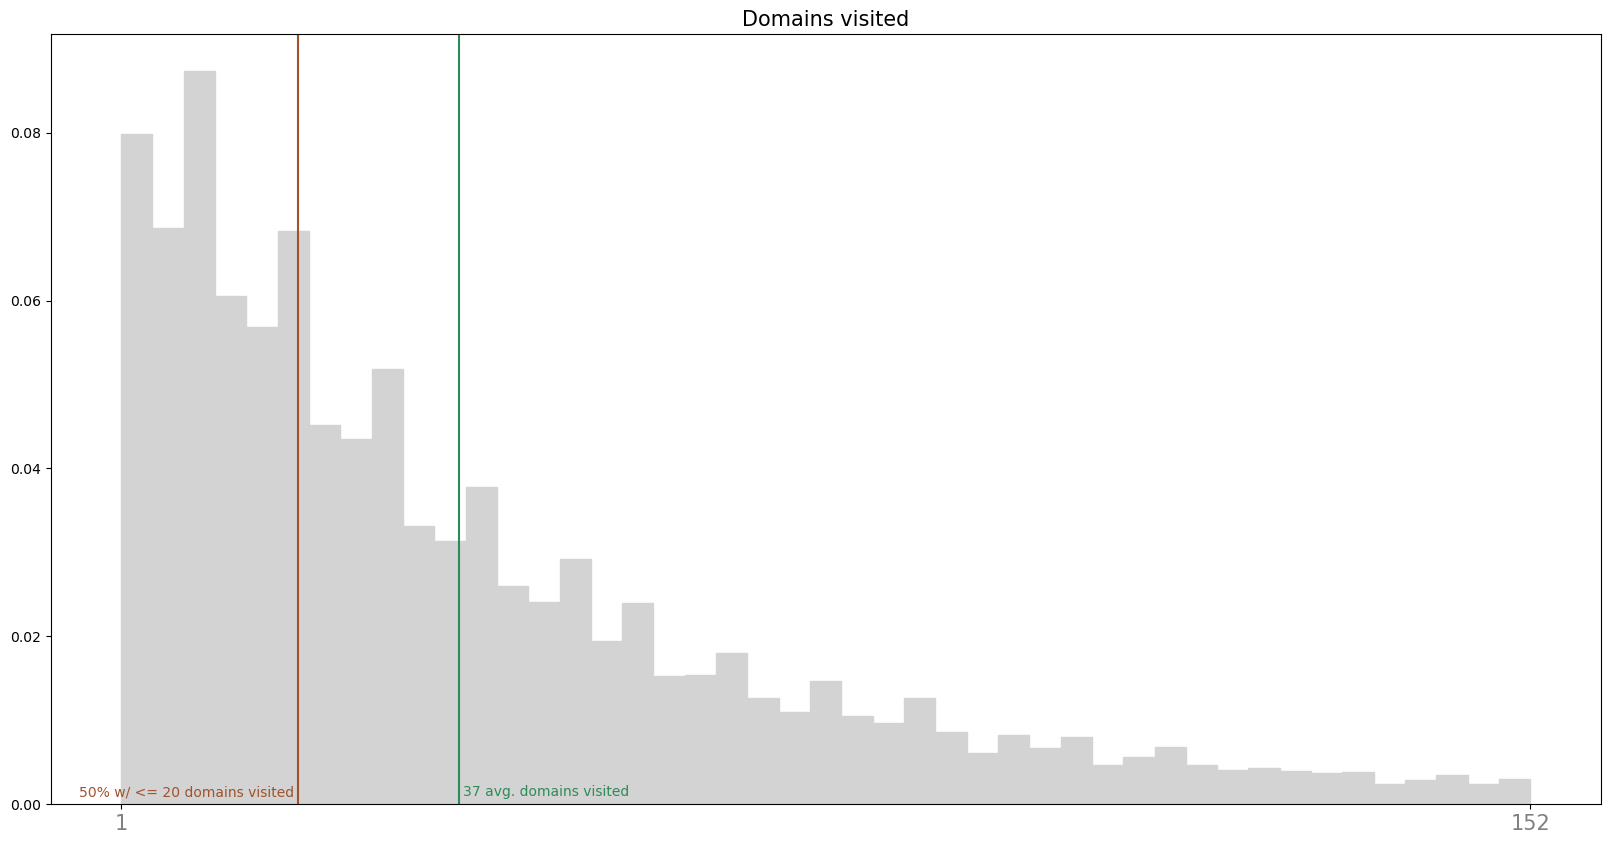

In [21]:
results.num_domains = results.num_domains.astype(float)

plt.figure(figsize=(20,10))
ax = plt.hist(results['num_domains'],weights=np.ones(len(results)) / len(results), bins = 45, color = 'lightgray', edgecolor = 'lightgray')

plt.axvline(results['num_domains'].mean(), 0, 1, color = color_1)
mean_value_label = f"{results['num_domains'].mean():,.0f} avg. domains visited"
plt.annotate(mean_value_label, (results['num_domains'].mean() + 0.5, 0), textcoords="offset points", xytext=(0, 6), ha='left', fontsize=10, color=color_1)

plt.axvline(20, 0, 1, color = color_2)
median_value_label = f"50% w/ <= 20 domains visited"
plt.annotate(median_value_label, (19.5, 0), textcoords="offset points", xytext=(0, 6), ha='right', fontsize=10, color=color_2)

# Set x-axis ticks to show only the first and last labels
xticks = [results['num_domains'].min(), results['num_domains'].max()]
plt.xticks(xticks, fontsize=15, color='gray')

plt.title('Domains visited', fontsize=15)
plt.show()

* TripAdvisor sessions visit on average 37 domains, which remains heavily skewed with a long tail distribution even after removing atypical values.
* The median of this sessions is 20 domains; this threshold is used to analyze to see the main behaviour pattern.

In [22]:
query_string = '''
    SELECT
        url_visit_domain
        ,domain_rank
        ,clickstream_queue
        ,fl_tripadvisor_session
        ,COUNT(session_id) as num_sessions
    FROM
    (
        SELECT
            max_doms.session_id
            ,doms.url_visit_domain
            ,doms.domain_rank
            ,dets.clickstream_queue
            ,max_doms.fl_tripadvisor_session
        FROM
        (
            SELECT
                session_id
                ,MAX(clickstream_queue) as num_domains
                ,MAX(fl_tripadvisor) as fl_tripadvisor_session
            FROM 
                `tripadvisorjourneys.journey_to_tripadvisor.dm_session_detail`
            GROUP BY
                session_id
            HAVING num_domains <= 20
                AND fl_tripadvisor_session = 1
        ) max_doms
        LEFT JOIN `tripadvisorjourneys.journey_to_tripadvisor.dm_session_detail` dets 
            ON (dets.session_id = max_doms.session_id) 
        LEFT JOIN `tripadvisorjourneys.journey_to_tripadvisor.dm_domains_summary` doms
            ON (doms.url_visit_domain = dets.url_visit_domain)
    ) doms
    GROUP BY
        url_visit_domain
        ,domain_rank
        ,clickstream_queue
        ,fl_tripadvisor_session
    ORDER BY
        num_sessions DESC
'''

results = bq_client.query(query_string).to_dataframe()
# Group domains to reduce dimensionality
results['domain_summarized'] = np.where(results.domain_rank < 20, results.url_visit_domain.str.replace('"',''), 'others')
results['domain_rank_summarized'] = np.where(results.domain_rank < 20, results.domain_rank, 20)

results

,url_visit_domain,domain_rank,clickstream_queue,fl_tripadvisor_session,num_sessions,domain_summarized,domain_rank_summarized
0,"""google.com""",1,1,1,3839,google.com,1
1,"""google.com""",1,2,1,3152,google.com,1
2,"""google.com""",1,3,1,2723,google.com,1
3,"""google.com""",1,4,1,2404,google.com,1
4,***TripAdvisor***,1,3,1,2269,***TripAdvisor***,1
...,...,...,...,...,...,...,...
26284,"""cascadeescapes.com""",165990,1,1,1,others,20
26285,"""nrmp.org""",216,7,1,1,others,20
26286,"""cubacubasandwicheria.com""",418603,7,1,1,others,20
26287,"""pocodiablo.com""",99915,3,1,1,others,20


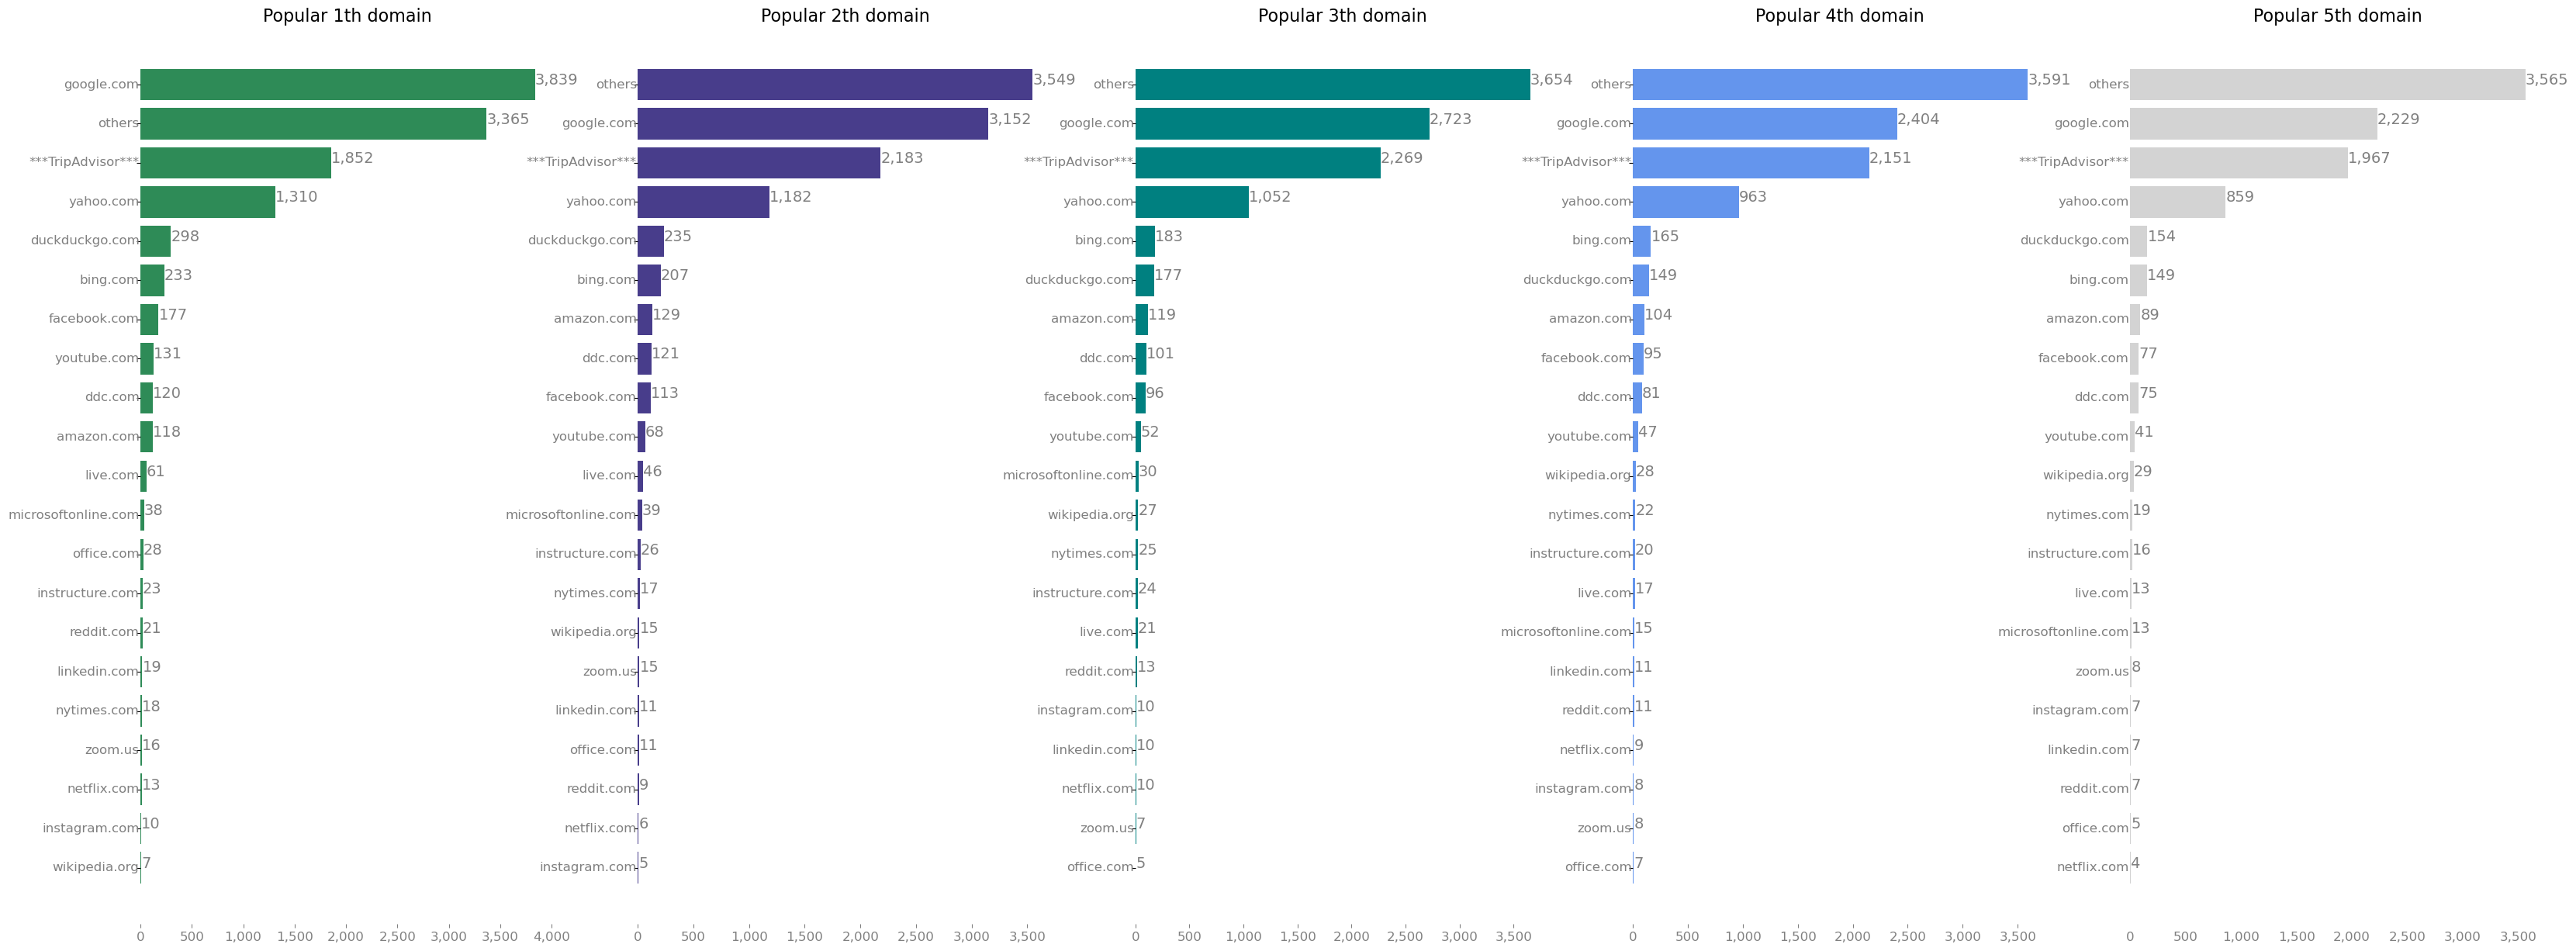

In [23]:
df = results[['domain_summarized','clickstream_queue','num_sessions']].groupby(['domain_summarized','clickstream_queue']).sum().reset_index()
fig, ax = plt.subplots(1,5, sharex =False,figsize=(40,15))
cols = [color_1, color_3, color_4, color_5, 'lightgray']

for k in range(0,5):
    df_aux = df[df.clickstream_queue == k+1].sort_values('num_sessions')
    df_aux.set_index('domain_summarized',inplace=True)
    df_aux = df_aux.astype(float)

    ax[k].barh(list(df_aux.index), df_aux['num_sessions'], label='# sessions', color = cols[k])    
    # ax[k].legend(bbox_to_anchor=(0.5, 1.07), loc='upper center', ncol=4, frameon=False, prop={'size': 12})
    totals = df_aux.num_sessions
    for i, total in enumerate(totals):
        ax[k].text( total, df_aux.index[i],'{:,.0f}'.format(total), ha='left', size = 14,color = "gray")

    # change the fontsize of minor ticks label 
    ax[k].tick_params(axis='x', which='major', labelsize=12, colors= 'gray')

    #Remove the y tick labels and plot them separately
    y= df_aux.index
    ax[k].set_yticklabels([]) 

    for i, yi in enumerate(y):
        ax[k].text(-11, yi, y[i], horizontalalignment='right', verticalalignment='center',color = "gray", size = 12)

    #add dollar to x axis
    ax[k].xaxis.set_major_formatter('{x:,.0f}')

    #Remove major ticks
    plt.tick_params(left = False, bottom = False)

    ax[k].set_title(f"Popular {k+1}th domain", fontsize=16)
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].spines['bottom'].set_visible(False)
    ax[k].spines['left'].set_visible(False)

#### Clickstream Markov chain 

In [162]:
query_string = '''
        SELECT
            DISTINCT
            ta_sess.session_id
            ,det.eventtimestamp
            ,doms.domain_encode
            ,doms.url_visit_domain
            ,doms.domain_rank
        FROM 
        (
            SELECT
                session_id
                ,MAX(fl_tripadvisor) as fl_tripadvisor_session
            FROM 
                `tripadvisorjourneys.journey_to_tripadvisor.dm_session_detail`
            GROUP BY
                session_id
            HAVING fl_tripadvisor_session = 1
        ) ta_sess
        LEFT JOIN
            `tripadvisorjourneys.journey_to_tripadvisor.dm_session_detail` det
            ON (det.session_id = ta_sess.session_id)
        LEFT JOIN
        (
            SELECT
                url_visit_domain
                ,domain_rank
                ,CASE WHEN url_visit_domain = "***TripAdvisor***" then "000TripAdvisor000"
                    WHEN domain_rank < 20 THEN CONCAT("domain_rank_",domain_rank)
                    ELSE "domain_rank_others" END AS domain_encode
            FROM `tripadvisorjourneys.journey_to_tripadvisor.dm_domains_summary`
        ) doms
            ON (doms.url_visit_domain = det.url_visit_domain)
        
'''

results = bq_client.query(query_string).to_dataframe()
df = results

In [178]:
df['domain_summarized'] = np.where(df.domain_rank < 20, df.url_visit_domain.str.replace('"',''), 'others')
df_aux = df.pivot_table(index='session_id',values='domain_summarized', aggfunc=lambda x: ','.join(x)).reset_index()
df_aux = df_aux.domain_summarized.apply(lambda x: x.split(',')).to_list()
len(df_aux)

26971

In [179]:
m = MarkovClickstream(df_aux)
m

In [180]:
m.pages

['***TripAdvisor***',
 'amazon.com',
 'bing.com',
 'ddc.com',
 'duckduckgo.com',
 'facebook.com',
 'google.com',
 'instagram.com',
 'instructure.com',
 'linkedin.com',
 'live.com',
 'microsoftonline.com',
 'netflix.com',
 'nytimes.com',
 'office.com',
 'others',
 'reddit.com',
 'wikipedia.org',
 'yahoo.com',
 'youtube.com',
 'zoom.us']

<Axes: >

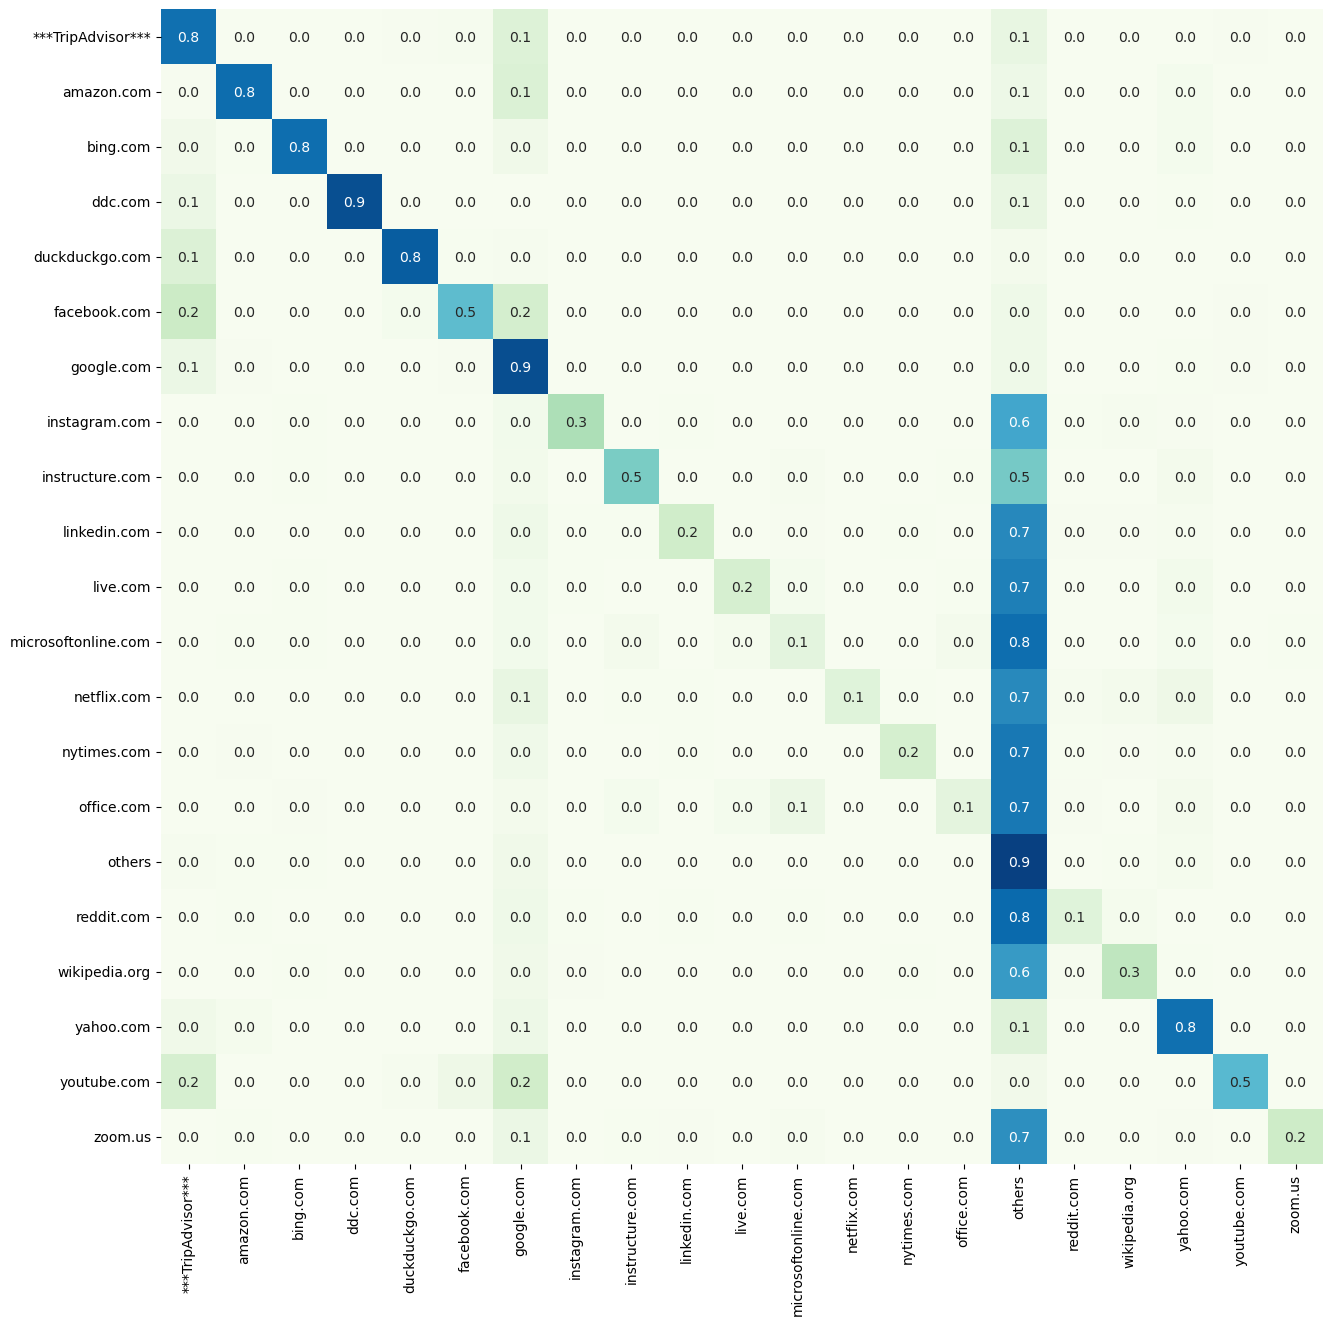

In [183]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
sns.heatmap(m.prob_matrix, xticklabels=m.pages, yticklabels=m.pages, annot=True, fmt='.1f', cbar=False, cmap='GnBu')

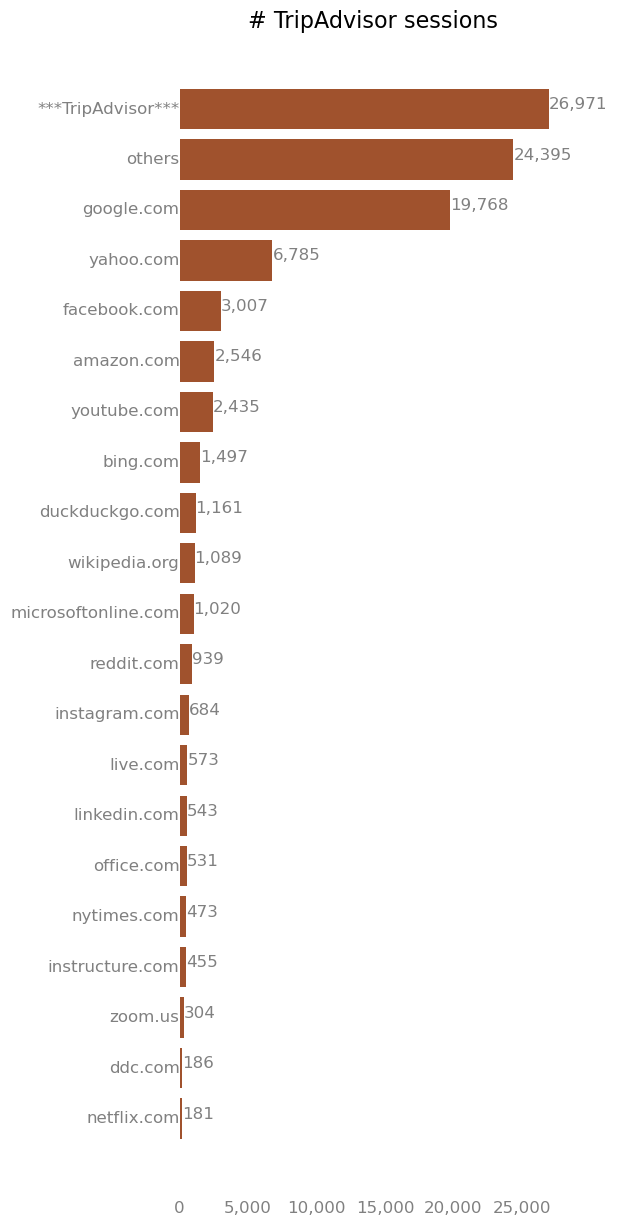

In [184]:
df_aux = df[['domain_summarized','session_id']].drop_duplicates().groupby('domain_summarized').count().reset_index().sort_values('session_id')
df_aux.columns = ['domain_summarized','num_sessions']
df_aux = df_aux.sort_values('num_sessions',ascending = True, ignore_index=True)

fig, ax = plt.subplots(1,1,figsize=(5,15))

ax.barh(df_aux['domain_summarized'], df_aux['num_sessions'], label='# sessions', color = color_2)    

totals = df_aux.num_sessions
for i, total in enumerate(totals):
    ax.text(total, df_aux['domain_summarized'][i],'{:,.0f}'.format(total), ha='left', size = 12, color = "gray")

# change the fontsize of minor ticks label 
ax.tick_params(axis='x', which='major', labelsize=12, colors= 'gray')

#Remove the y tick labels and plot them separately
y= df_aux['domain_summarized']
ax.set_yticklabels([]) 

for i, yi in enumerate(y):
    ax.text(-11, yi, y[i], horizontalalignment='right', verticalalignment='center',color = "gray", size = 12)

#add dollar to x axis
ax.xaxis.set_major_formatter('{x:,.0f}')

#Remove major ticks
plt.tick_params(left = False, bottom = False)

ax.set_title(f"# TripAdvisor sessions", fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [188]:
from markovclick.viz import visualise_markov_chain
graph = visualise_markov_chain(m)

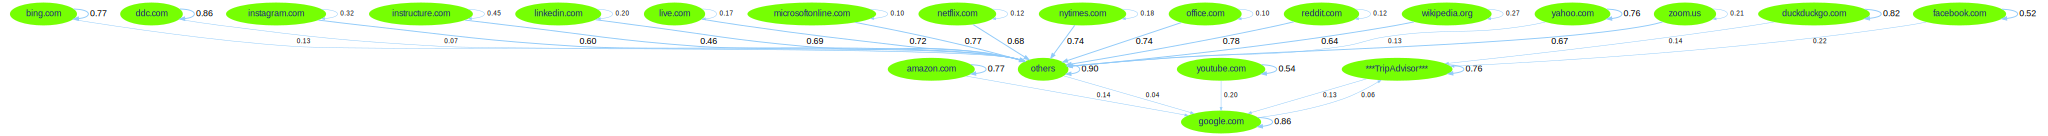

In [189]:
graph